# Processing und Downsampling

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sklearn.cluster as sk
from PIL import Image
from torchvision import transforms

In [2]:
def displayimage(imgarr, r=1, c=3):
    plt.figure(figsize=(18,32))
    count = 1
    for i in range(1,r+1):
        for j in range(1,c+1):
            plt.subplot(r,c,count)
            plt.imshow(imgarr[count-1])
            count += 1
    plt.show() 

In [3]:
img = cv2.cvtColor(cv2.imread('images/nur.jpg'), cv2.COLOR_BGR2RGB)
croptrans = transforms.CenterCrop((100,100))
imcrop = croptrans(Image.fromarray(img))
blur = cv2.blur(img,(5,5))
gblur = cv2.GaussianBlur(img,(3,3),0)
median = cv2.medianBlur(img,9)
bilin = cv2.bilateralFilter(img,9,75,75)

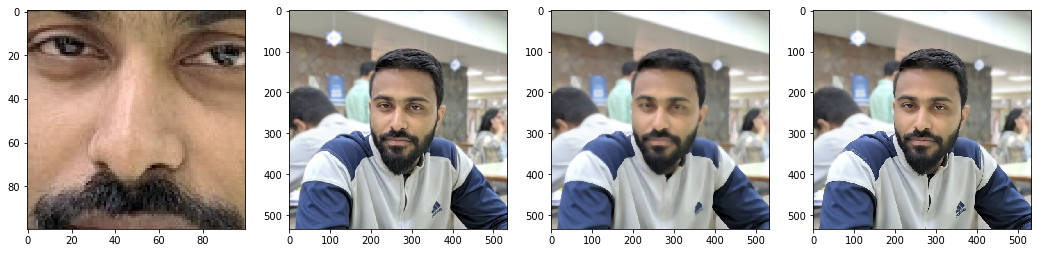

In [4]:
imgarray = []
imgarray.append(imcrop)
imgarray.append(gblur)
imgarray.append(median)
imgarray.append(bilin)
displayimage(imgarray,r=1,c=4)

(<matplotlib.axes._subplots.AxesSubplot at 0x2b040f20ef0>,
 Text(0.5, 1.0, 'Quantized'))

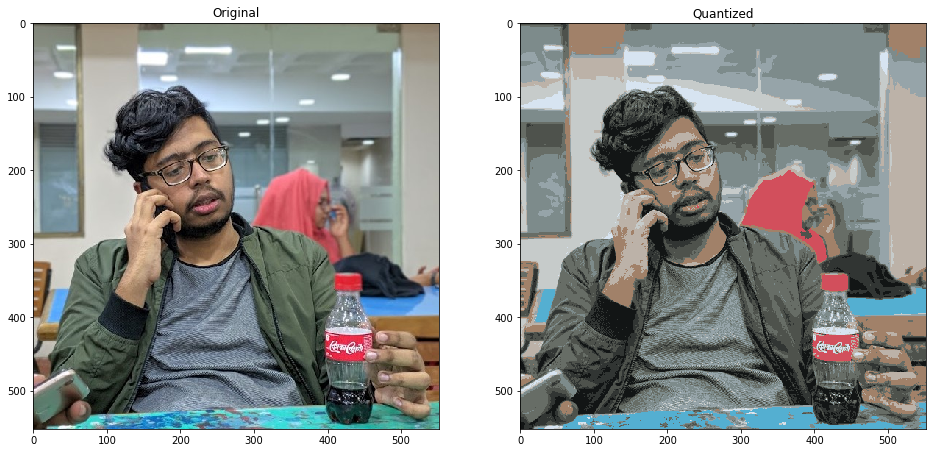

In [5]:
original = cv2.cvtColor(cv2.imread('images/abr.jpg'), cv2.COLOR_BGR2RGB)
n_colors = 12

arr = original.reshape((-1, 3))
kmeans = sk.MiniBatchKMeans(n_clusters=n_colors, random_state=42).fit(arr)
labels = kmeans.labels_
centers = kmeans.0
less_colors = centers[labels].reshape(original.shape).astype('uint8')

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(original),plt.title('Original')
plt.subplot(122),plt.imshow(less_colors),plt.title('Quantized')

In [6]:
blur = cv2.blur(less_colors,(5,5))
gblur = cv2.GaussianBlur(less_colors,(7,7),0)
median = cv2.medianBlur(less_colors,5)
# bilin = cv2.bilateralFilter(less_colors,9,75,75)
downed = cv2.resize(median, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

<Figure size 1296x1152 with 0 Axes>

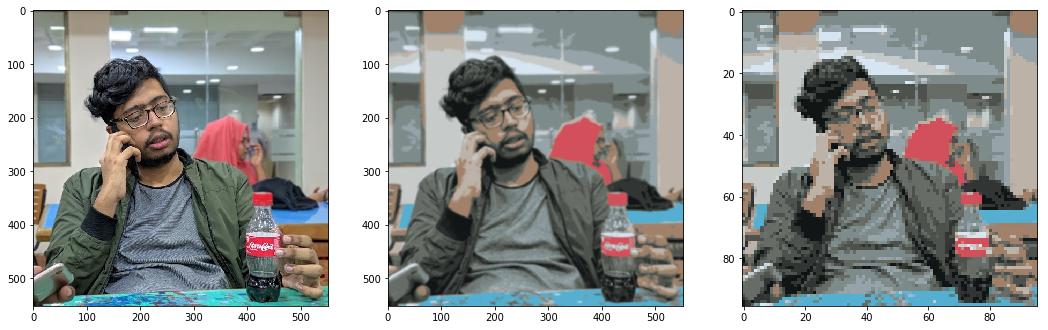

In [7]:
plt.figure(figsize=(18,16))
imgarray = []
imgarray.append(original)
imgarray.append(gblur)
imgarray.append(downed)
displayimage(imgarray,r=1,c=3)

# DataLoading

In [1]:
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
from PIL import Image

In [4]:
class Picsle8DS(D.Dataset):
    
    def __init__(self, root):
        """ Intialize the dataset """
        self.filearray = []
        self.labels = []
        self.root = root
        self.transform = transforms.ToTensor()
        filenames = glob.glob(osp.join(self.root+'Pixelart/', '*.jpg'))
        for fn in filenames:
            self.filearray.append(fn)
            self.labels.append(1)
        filenames = glob.glob(osp.join(self.root+'Realpix/', '*.jpg'))
        for fn in filenames:
            self.filearray.append(fn)
            self.labels.append(0)
        self.len = len(self.filearray)
        
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        image = Image.open(self.filearray[index])
        if image.size[0] != image.size[1]:
            sqrsize = min(image.size)
            croptrans = transforms.CenterCrop((sqrsize,sqrsize))
            image = croptrans(image)
        nimage = image.resize((192, 192), Image.NEAREST)
        nimage = nimage.convert('RGB')
        label = self.labels[index]
        return self.transform(nimage), label

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len

In [5]:
path = 'images/'
# Simple dataset. Only save path to image and load it and transform to tensor when call __getitem__.
pixelDSlist = Picsle8DS(path)
# total images in set
print(pixelDSlist.len,'images from the dataset')

774 images from the dataset


In [10]:
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(pixelDSlist, batch_size=32, shuffle=False, num_workers=0)
dataiter = iter(loader)

# functions to show an image
def torchimshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([32, 3, 192, 192])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


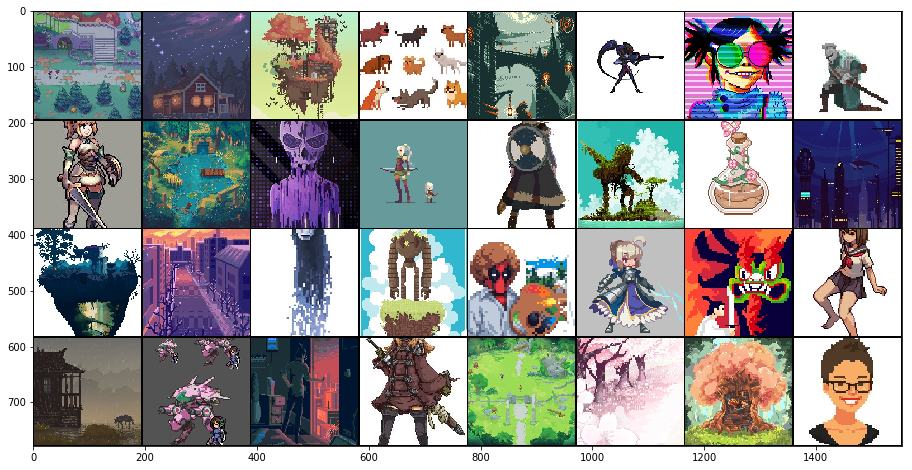

In [11]:
# get some images
images, labels = dataiter.next()
print(images.shape)

# show images
plt.figure(figsize=(18,8))
torchimshow(torchvision.utils.make_grid(images))
print(labels)

In [58]:
train_len = int(0.7*pixelDSlist.len)
valid_len = pixelDSlist.len - train_len
train, valid = D.random_split(pixelDSlist, lengths=[train_len, valid_len]) 
len(train), len(valid)

(482, 208)

Train: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0])
Valid: tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1])


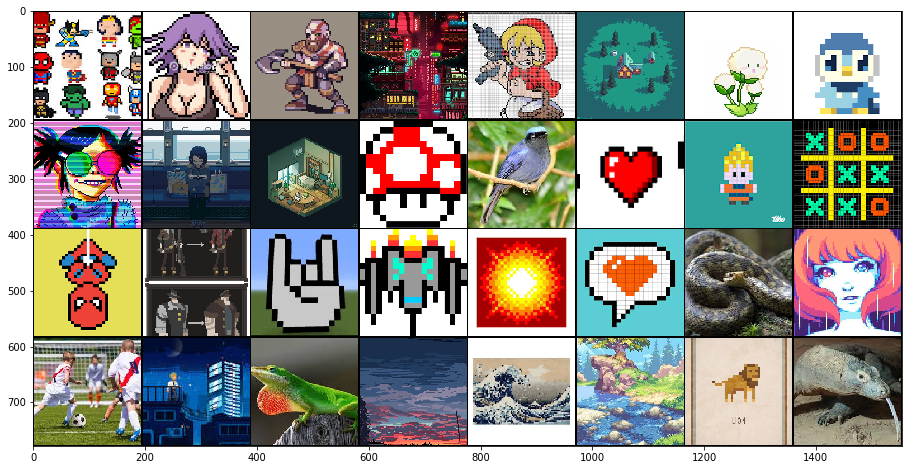

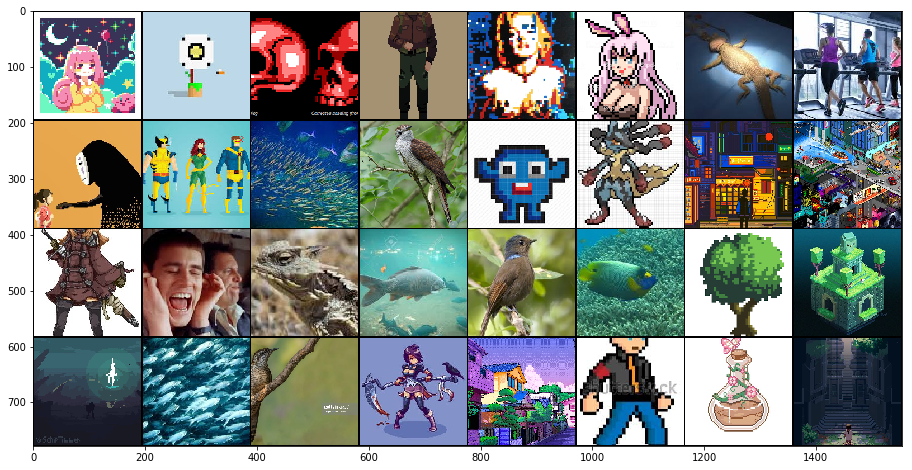

In [61]:
# Use the torch dataloader to iterate through the dataset
trainloader = D.DataLoader(train, batch_size=32, shuffle=False, num_workers=0)
validloader = D.DataLoader(valid, batch_size=32, shuffle=False, num_workers=0)

# get some images
dataiter_tr = iter(trainloader)
dataiter_vl = iter(validloader)
images_t, labels_t = dataiter_tr.next()
images_v, labels_v = dataiter_vl.next()

# show images
plt.figure(figsize=(16,8))
torchimshow(torchvision.utils.make_grid(images_t))
print('Train:',labels_t)
plt.figure(figsize=(16,8))
torchimshow(torchvision.utils.make_grid(images_v))
print('Valid:',labels_v)

In [25]:
filearray = []
labels = []
filenames = glob.glob(osp.join('images/Pixelart/', '*.jpg'))
for fn in filenames:
    filearray.append(fn)
    labels.append(1)
    filenames = glob.glob(osp.join('images/Realpix/', '*.jpg'))
for fn in filenames:
    filearray.append(fn)
    labels.append(0)
length = len(filearray)

imgarr = []
for index in range(0,length):
    image = Image.open(filearray[index])
    if image.size[0] != image.size[1]:
        sqrsize = min(image.size)
        croptrans = transforms.CenterCrop((sqrsize,sqrsize))
        image = croptrans(image)
    nimage = image.resize((192, 192), Image.NEAREST)
    nimage = nimage.convert('RGB')
    img = np.array(nimage)
    imgarr.append(img)
imgarr = np.array(imgarr)
# imgarr = np.moveaxis(imgarr,3,1)
t = transforms.ToTensor()
print(imgarr.shape, t(nimage).shape, t(imgarr[0]).shape, len(labels))

np.save('picsle8_ImageArray_774RGB',imgarr)
np.save('picsle8_LabelArray_774',labels)

(774, 192, 192, 3) torch.Size([3, 192, 192]) torch.Size([3, 192, 192]) 774


In [26]:
npzimg = np.load('picsle8_ImageArray_774RGB.npy')
npzlbl = np.load('picsle8_LabelArray_774.npy')

print(npzimg.shape, npzlbl.shape)

(774, 192, 192, 3) (774,)
